In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

import seaborn as sns

# Definir carpetas y archivos a utilizar
---
Arbol de archivos
```bash
 root
 ├───Codigos Python
 ├───Datos
 |   ├───Datos_CEN: Informacion de generacion historica en archivos .tsv para cada mes. Fuente:
 |   ├───Capacidad Instalada.xlsx: Informacion de capacidad instalada para cada mes. Fuente:
 |   └───Coordenadas.xlsx: Informacion de ubicacion geografica de centrales. Fuente:
 ├───Figuras: Carpeta que contiene las figuras de los codigos
 └───Output: Carpeta que contiene salidas de los programas, ejemplo: generación por cluster
 ```

In [31]:
Hidro = False

In [32]:
root_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))

# Directorios principales
Estudio_Principal_dir = os.path.join(root_dir, 'a. Estudio Principal')
ProcesamientoDatos_dir = os.path.join(Estudio_Principal_dir, 'a. Procesamiento de datos')
Estudios_dir = os.path.join(Estudio_Principal_dir, 'b. Estudios preliminares Sistema')
Simulacion_dir = os.path.join(Estudio_Principal_dir, 'c. Simulacion sistema')

# Datos de entrada
DatosEntrada_dir = os.path.join(root_dir, '1. Datos de entrada')
GenData_dir = os.path.join(DatosEntrada_dir, 'Generacion')
datosCEN_dir = os.path.join(GenData_dir, 'Datos_CEN')

# Datos de generacion procesados
DatosProcesados_dir = os.path.join(ProcesamientoDatos_dir, 'Output')

# Directorios de procesamiento de datos
Figuras_dir = os.path.join(Estudios_dir, 'Figuras')

#Crear las carpetas que no existan
if not os.path.exists(Figuras_dir): os.makedirs(Figuras_dir)

In [33]:
# Parametros de entrada (deben ser modificados dependiendo de los años a analizar)
years = [2020,2021,2022,2023,2024]  # Vector con los años a analizar
last_year_month = 6  # Mes del último año a analizar, si se tiene el año completo utilizar 12

# Parametros fijos
last_day = {'01':31,'02':28,'03':31,'04':30,'05':31,'06':30,'07':31,'08':31,'09':30,'10':31,'11':30,'12':31}
Años_bisiestos = [2020,2024,2028,2032,2036,2040,2044,2048,2052,2056,2060]  # Años bisiestos
meses = ['enero','febrero','marzo','abril','mayo','junio','julio','agosto','septiembre','octubre','noviembre','diciembre']  # Vector con los meses del año
months_numbers = {'enero':'01','febrero':'02','marzo':'03','abril':'04','mayo':'05','junio':'06','julio':'07','agosto':'08','septiembre':'09','octubre':'10','noviembre':'11','diciembre':'12'}  # Diccionario que relaciona el nombre del mes con su número
numbers_months = {1:'Enero',2:'Febrero',3:'Marzo',4:'Abril',5:'Mayo',6:'Junio',7:'Julio',8:'Agosto',9:'Septiembre',10:'Octubre',11:'Noviembre',12:'Diciembre'}  # Diccionario que relaciona el número del mes con su nombre

In [34]:
def cargar_dataset(Data_dir):
    df_sol_data = pd.read_parquet(os.path.join(Data_dir, 'df_sol_data.parquet'))
    df_eol_data = pd.read_parquet(os.path.join(Data_dir, 'df_eol_data.parquet'))
    df_hid_data = pd.read_parquet(os.path.join(Data_dir, 'df_hid_data.parquet'))

    df_PotenciaSistema = pd.read_parquet(os.path.join(Data_dir, 'df_PotenciaSistema.parquet'))

    df_sol_info = pd.read_excel(os.path.join(Data_dir, 'df_GenInfo.xlsx'), sheet_name='Solar')
    df_eol_info = pd.read_excel(os.path.join(Data_dir, 'df_GenInfo.xlsx'), sheet_name='Eolica')
    df_hid_info = pd.read_excel(os.path.join(Data_dir, 'df_GenInfo.xlsx'), sheet_name='Hidro')

    df_tech_data = [df_sol_data, df_eol_data, df_hid_data]
    df_tech_info = [df_sol_info, df_eol_info, df_hid_info]

    return df_tech_data, df_tech_info, df_PotenciaSistema

def getGenSistema(dfs_data,columnas):
    dfs = []
    for df,column in zip(dfs_data,columnas):
        df_gen = df.set_index(["Year","Month","Day","Hour"]).sum(axis=1).to_frame().reset_index().rename(columns={0:column})
        dfs.append(df_gen[column])
    df_gen_sistema = pd.concat(dfs,axis=1)
    df_YearMonthDayHour = dfs_data[0][["Year","Month","Day","Hour"]]
    df_gen_sistema = pd.concat([df_YearMonthDayHour,df_gen_sistema],axis=1)
    return df_gen_sistema

In [35]:
[df_sol_data, df_eol_data, df_hid_data], [df_sol_info, df_eol_info, df_hid_info], df_PotenciaSistema = cargar_dataset(DatosProcesados_dir)

if Hidro:
    df_GenSistema = getGenSistema([df_sol_data, df_eol_data, df_hid_data],['Solar','Eolica','Hidro'])
    dfs_GenCentrales = {"Solar": df_sol_data,
                        "Eolica": df_eol_data,
                        "Hidro": df_hid_data}
else:
    df_GenSistema = getGenSistema([df_sol_data, df_eol_data],['Solar','Eolica'])
    dfs_GenCentrales = {"Solar": df_sol_data,
                        "Eolica": df_eol_data}

### Metodologia para calculo de CapacidadMensual efectiva
---
En orden de calcular la capacidad instalada mensual efectiva del sistema lo que se utiliza es el máximo de generación reportada al coordinador, este máximo es comparado con los máximos en meses anteriores a modo de evitar considerar un máximo inferior al reportado para la central

In [36]:
df_CapSistema_Month = pd.read_csv(os.path.join(Estudios_dir,'Output','CapacidadInstalada.csv'))

$
fp_{month} = \frac{\sum{Pot}}{Hours\cdot Cap}
$

In [37]:
if not Hidro:
    df_CapSistema_Month = df_CapSistema_Month.drop(columns=['Hidro'])

In [38]:
def calcular_fp_month(df_Gen, df_Cap):
    # Paso 1: Calcular la energia mensual
    df_Ener = df_Gen.groupby(['Year','Month']).sum().drop(columns=['Day','Hour'])

    hours_month = {1:31*24,2:28*24,3:31*24,4:30*24,5:31*24,6:30*24,7:31*24,8:31*24,9:30*24,10:31*24,11:30*24,12:31*24}
    for tech in df_Ener.columns:
        df_Ener[tech] = df_Ener.apply(lambda x: x[tech]/hours_month[x.name[1]],axis=1)

    # Paso 2: Calcular el factor de planta mensual
    df_fp = df_Ener.div(df_Cap.set_index(['Year','Month']),axis=1)
    return df_fp

def calcular_fp_year(df_Gen, fp_month):
    # Paso 1: Calcular la energia mensual
    df_Ener = df_Gen.groupby(['Year','Month']).sum().drop(columns=['Day','Hour'])

    # Paso 1.5: Calcular la energia anual
    df_Ener_year = df_Gen.groupby(['Year']).sum().drop(columns=['Month','Day','Hour'])

    # Paso 2: Multiplicar la energia mensual por el factor de planta mensual
    df_fp = df_Ener.mul(fp_month,axis=0)

    # Paso 3: Calcular el factor de planta anual
    df_fp = df_fp.groupby('Year').sum()
    df_fp = df_fp.div(df_Ener_year,axis=1)
    return df_fp

df_fp_month = calcular_fp_month(df_GenSistema, df_CapSistema_Month)
df_fp_year = calcular_fp_year(df_GenSistema, df_fp_month)


In [41]:
def get_MinMaxFps(fp_intput):
    fp_min = min(fp_intput)
    fp_max = max(fp_intput)
    return fp_min, fp_max

# Encontrar el minimo y maximo fp para cada tecnologia
fp_eol_min, fp_eol_max = get_MinMaxFps(df_fp_month["Eolica"])
fp_sol_min, fp_sol_max = get_MinMaxFps(df_fp_month["Solar"])
if Hidro: fp_hid_min, fp_hid_max = get_MinMaxFps(df_fp_month["Hidro"])

print("="*20)
print('fp_sol_min:', round(fp_sol_min,2))
print('fp_sol_max:', round(fp_sol_max,2))
print("="*20)
print('fp_eol_min:', round(fp_eol_min,2))
print('fp_eol_max:', round(fp_eol_max,2))
print("="*20)
if Hidro:
    print('fp_hid_min:', round(fp_hid_min,2))
    print('fp_hid_max:', round(fp_hid_max,2))
    print("="*20)

fp_sol_min: 0.17
fp_sol_max: 0.42
fp_eol_min: 0.22
fp_eol_max: 0.43


# Graficar
---

In [44]:
if Hidro:
    colors = {'Eólico':"#a8acb0",'Solar FV':"#ee9f20",'Hidro':"#5b97ca"}
else:
    colors = {'Eólico':"#5b97ca",'Solar FV':"#ee9f20"}

[ 6 18 30 42 54]


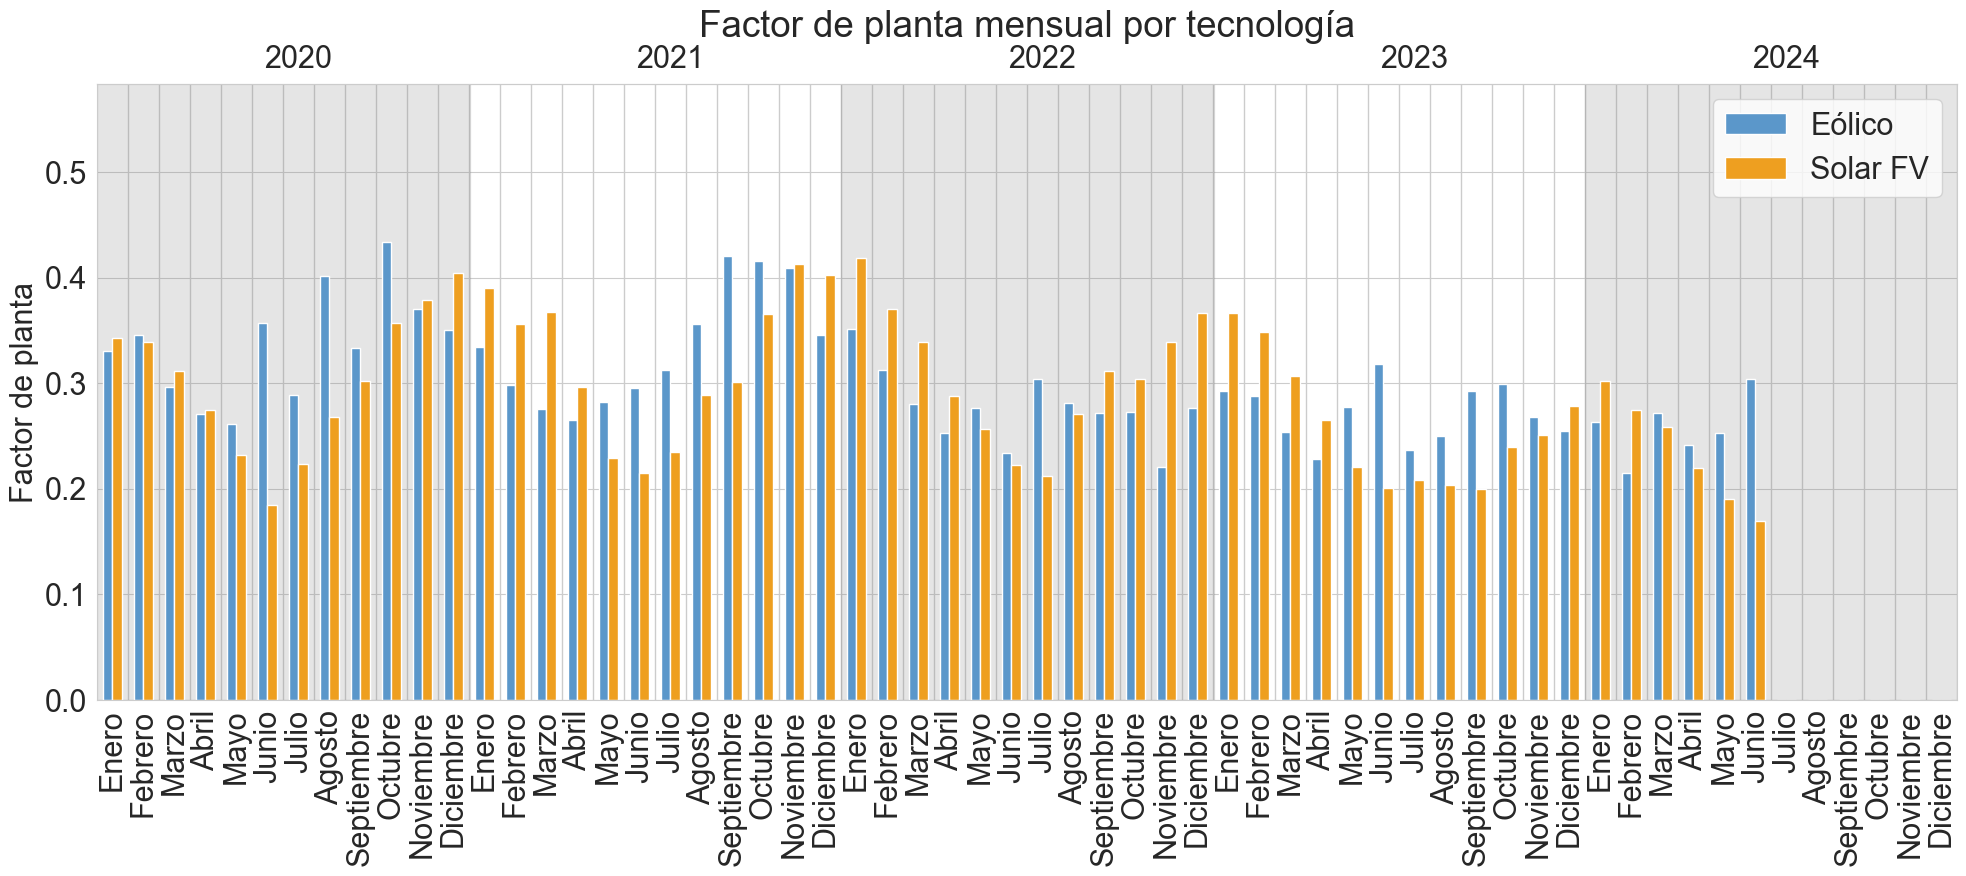

In [45]:
def graficar_fp(df_fp_month, save_folder):

    # Revisar si el ultimo año tiene todos los meses, en caso contrario se agregan los meses faltantes
    # con un factor de planta de 0

    last_year = df_fp_month['Year'].unique()[-1]
    last_month = df_fp_month[df_fp_month['Year']==last_year]['Month'].unique()[-1]
    if last_month<12:
        dfs_append = [df_fp_month]
        columns = df_fp_month.columns
        for month in range(last_month+1,13):
            df_append = pd.DataFrame([[last_year,month]+[0]*len(columns[2:])],columns=columns)
            dfs_append.append(df_append)
        df_fp_month = pd.concat(dfs_append)
            
    fp_eol = df_fp_month['Eolica'].values
    fp_solar = df_fp_month['Solar'].values
    if Hidro: fp_hidro = df_fp_month['Hidro'].values

    sns.set_style("whitegrid")

    # Cambiar el tamaño de la fuente
    plt.rcParams.update({'font.size': 22})
    years = list(df_fp_month.Year.unique())
    meses = list(df_fp_month.Month.unique())

    meses = [numbers_months[mes] for mes in meses]

    n_years = len(years)
    n_meses = n_years*12

    x_axis = np.arange(n_meses)
    meses = meses*n_years

    # Se grafican los factores de planta mensuales calculados
    fig,ax = plt.subplots(figsize=(24,8))

    for i in range(1,n_years+1):
        idx = i-1
        if idx%2==0:
            rango = [(idx/2)*24-0.5,11.525+24*(idx/2)]
            plt.fill_between(rango, 0, 1, color='gray', alpha=0.2)

    #for i in range(1,n_years):
    #    plt.vlines(i*12-0.5, 0, 1, color='k', linestyle='--', linewidth=1)

    if Hidro:
        plt.bar(x_axis-0.3, fp_eol, 0.3, label='Eólico', color=colors['Eólico'])
        plt.bar(x_axis, fp_solar, 0.3, label='Solar FV', color=colors['Solar FV'])
        plt.bar(x_axis+0.3, fp_hidro, 0.3, label='Hidro', color=colors['Hidro'])
    else:
        plt.bar(x_axis-0.15, fp_eol, 0.3, label='Eólico', color=colors['Eólico'])
        plt.bar(x_axis+0.15, fp_solar, 0.3, label='Solar FV', color=colors['Solar FV'])

    secx = ax.secondary_xaxis('top')
    secx.set_xticks(np.arange(6, n_meses-6+1, 12))
    print(np.arange(6, n_meses-6+1, 12))
    secx.set_xticklabels(years)
    secx.tick_params(top = False)

    meses_cap = [mes.capitalize() for mes in meses]
    plt.xticks(x_axis, meses_cap, rotation=90)
    plt.xlim(-0.5,n_meses-0.5)

    # Guardar valores de ylim
    if Hidro:
        ylim = (0,max(max(fp_eol),max(fp_solar),max(fp_hidro))+0.15)
    else:
        ylim = (0,max(max(fp_eol),max(fp_solar))+0.15)

    plt.ylim(ylim)
    plt.ylabel('Factor de planta')
    plt.legend(loc='upper right')

    ax.set_xticks(x_axis+0.5,minor=True)
    ax.grid(which='minor', axis='x', linestyle='-', linewidth=1)
    ax.grid(which='major', axis='x', linestyle='-', linewidth=0)

    plt.title(f'Factor de planta mensual por tecnología')

    if Hidro:
        save_fig = os.path.join(save_folder, f'FactoresPlanta.png')
    else:
        save_fig = os.path.join(save_folder, f'FactoresPlanta_SinHidro.png')
    fig.savefig(save_fig, dpi=300, bbox_inches="tight")

save_folder = os.path.join(Figuras_dir,"Factores de Planta 3D")
if not os.path.exists(save_folder): os.makedirs(save_folder)

graficar_fp(df_fp_month.reset_index(), save_folder)